# 10/16 Redoing (again) current restructure_data_compute_transports

In [466]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [467]:
#Packages 
import numpy as np
import xarray as xr
import cmocean.cm as cmo
import matplotlib.pyplot as plt
import mpas_tools

from geometric_features import GeometricFeatures
from geometric_features import read_feature_collection

from mpas_tools.mesh.mask import compute_mpas_region_masks
from mpas_tools.parallel import create_pool
from mpas_tools.io import write_netcdf

import geojson
import json
import mosaic
import os.path
import mpasregions.sections as mps
import gsw
import warnings 
import glob
from xgcm import Grid

In [468]:
# open mesh and filepaths
# global mesh
mesh_path = '/global/cfs/projectdirs/e3sm/inputdata/ocn/mpas-o/EC30to60E2r2/ocean.EC30to60E2r2.210210.nc'
mesh = xr.open_dataset(mesh_path)
mesh = mesh.assign_coords({
"VertexID": xr.DataArray(mesh.indexToVertexID, dims=('nVertices',)),
})

# global data
bmm_filepath = '/pscratch/sd/b/bmoorema/run_001_062/'
dso = xr.open_dataset(bmm_filepath + '20210421_sim7_CORE_60to30E2r2.mpaso.hist.am.timeSeriesStatsMonthly.0063-12-01.nc')

# open base mask that we will fill with 0s according to the original mask (this new mask will contain cells PLUS their corresponding edges and vertices)
# base_mask = xr.open_dataset('./mpas-o_EC30to60_global_base_mask.nc')


/tmp/ipykernel_107252/4089359426.py:11: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  dso = xr.open_dataset(bmm_filepath + '20210421_sim7_CORE_60to30E2r2.mpaso.hist.am.timeSeriesStatsMonthly.0063-12-01.nc')


In [469]:
# open datasets with just the variables that we want

months = ['01','02','03','04','05','06','07','08','09','10','11','12']
ds_list = []

prefix = '20210421_sim7_CORE_60to30E2r2.mpaso.hist.am.timeSeriesStats'

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for i in range(0,12):
        month = months[i]
        file = prefix + f'Monthly.0060-{month}-01.nc'
        file_glob = glob.glob(file)
        ds = xr.open_dataset(bmm_filepath + file)[['xtime_startMonthly','timeMonthly_avg_normalVelocity','timeMonthly_avg_potentialDensity','timeMonthly_avg_layerThickness',
                                                   'nCells','nEdges','nVertLevels','nVertLevelsP1']]
        ds_xtime_startMonthly = ds.swap_dims({'Time':'xtime_startMonthly'})
        ds_list.append(ds_xtime_startMonthly)

dss = xr.concat(ds_list,dim='xtime_startMonthly')

In [470]:
dss['maxLevelCell'] = mesh.maxLevelCell

In [471]:
# set up descriptor for plotting 

mesh.attrs['is_periodic'] = 'YES'
mesh.attrs['x_period'] = 360
mesh.attrs['y_period'] = 0.0

descriptor = mosaic.Descriptor(mesh,use_latlon=False)

In [472]:
# get edges and vertices of mask made from transect from algorithm
alg_edges, alg_vertices, dsMasks = mps.open_transect_from_alg(mesh)

# get edges and vertices of mask made from mask
# get edges and vertices of mask made from mask
mask_edges, mask_vertices, mask = mps.open_from_mask(mesh)

LS_test_transect_from_alg.geojson exists!
Opening LS_test_transect_from_alg.nc as dsMasks
Opening LS_test_transect_from_mask.nc file as mask


# Set up choice of coordinates

In [473]:
method = 'alg' # 'mask'
if method == 'alg':
    edges, vertices = alg_edges, alg_vertices
    mask = dsMasks

if method == 'mask':
    edges, vertices = mask_edges, mask_vertices
    mask = mask

In [474]:
# USING FFILL
# get only the cells on transect edges
xr_cellsOnTransectEdges = mps.n_to_xr_idx(mesh.cellsOnEdge.isel(nEdges = edges))
dss_transect_edges = dss.isel(nEdges = edges, nCells = xr_cellsOnTransectEdges)

# make a datavariable that holds the order of the nEdges in the transect
dss_transect_edges['transect_edgesOrdered'] = xr.DataArray(np.arange(0,edges.size),dims='nEdges')
dss_transect_edges

# we now have a dataset with cells and edges that are bordering the transect surrounding the mask

# modify the potential density to fill all land values with the potential density of the last ocean cell
thickLayers_ocean = dss_transect_edges.timeMonthly_avg_layerThickness > 1
dss_transect_edges['timeMonthly_avg_potentialDensity'] = dss_transect_edges.timeMonthly_avg_potentialDensity.where(thickLayers_ocean).ffill(dim='nVertLevels',limit=None)

# make the potential density sit on edges by taking the mean of the potential density of the two cells adjacent to that edge
dss_transect_edges['timeMonthly_avg_potentialDensity_Edge'] = dss_transect_edges.timeMonthly_avg_potentialDensity.mean(dim='TWO')

# interpolate the potential density values onto nVertLevelsP1 coordinates
# create an xgcm grid
grid = Grid(dss_transect_edges, coords={'Z':{'center':'nVertLevels','outer':'nVertLevelsP1'}},periodic=False,autoparse_metadata=False)

# interpolate
# these values shouldn't exactly match nVertLevels valuse, right?
dss_transect_edges['timeMonthly_avg_potentialDensity_EdgeP1'] = grid.interp(dss_transect_edges.timeMonthly_avg_potentialDensity_Edge,'Z',boundary='extend')

dss_transect_edges = dss_transect_edges.assign_coords({'transect_edgesOrdered': dss_transect_edges.transect_edgesOrdered})

Text(0.5, 1.0, 'ffill, layerThickness > 1 only')

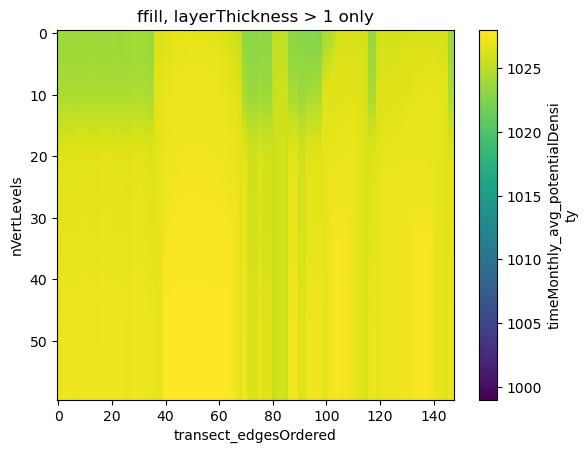

In [475]:
dss_transect_edges.timeMonthly_avg_potentialDensity.mean(dim=['xtime_startMonthly','TWO']).swap_dims({'nEdges':'transect_edgesOrdered'}).plot(y='nVertLevels',vmin=999,vmax=1028)
plt.gca().invert_yaxis()
plt.title('ffill, layerThickness > 1 only')

In [476]:
# NO FFILL, APPLY LAYERTHICKNESS MASK
# get only the cells on transect edges
xr_cellsOnTransectEdges = mps.n_to_xr_idx(mesh.cellsOnEdge.isel(nEdges = edges))
dss_transect_edges = dss.isel(nEdges = edges, nCells = xr_cellsOnTransectEdges)

# make a datavariable that holds the order of the nEdges in the transect
dss_transect_edges['transect_edgesOrdered'] = xr.DataArray(np.arange(0,edges.size),dims='nEdges')
dss_transect_edges

# we now have a dataset with cells and edges that are bordering the transect surrounding the mask

# modify the potential density to fill all land values with the potential density of the last ocean cell
thickLayers_ocean = dss_transect_edges.timeMonthly_avg_layerThickness > 1
dss_transect_edges['timeMonthly_avg_potentialDensity'] = dss_transect_edges.timeMonthly_avg_potentialDensity.where(thickLayers_ocean)

# make the potential density sit on edges by taking the mean of the potential density of the two cells adjacent to that edge
dss_transect_edges['timeMonthly_avg_potentialDensity_Edge'] = dss_transect_edges.timeMonthly_avg_potentialDensity.mean(dim='TWO')

# interpolate the potential density values onto nVertLevelsP1 coordinates
# create an xgcm grid
grid = Grid(dss_transect_edges, coords={'Z':{'center':'nVertLevels','outer':'nVertLevelsP1'}},periodic=False,autoparse_metadata=False)

# interpolate
# these values shouldn't exactly match nVertLevels valuse, right?
dss_transect_edges['timeMonthly_avg_potentialDensity_EdgeP1'] = grid.interp(dss_transect_edges.timeMonthly_avg_potentialDensity_Edge,'Z',boundary='extend')

dss_transect_edges = dss_transect_edges.assign_coords({'transect_edgesOrdered': dss_transect_edges.transect_edgesOrdered})

Text(0.5, 1.0, 'No ffill, layerThickness > 1 only')

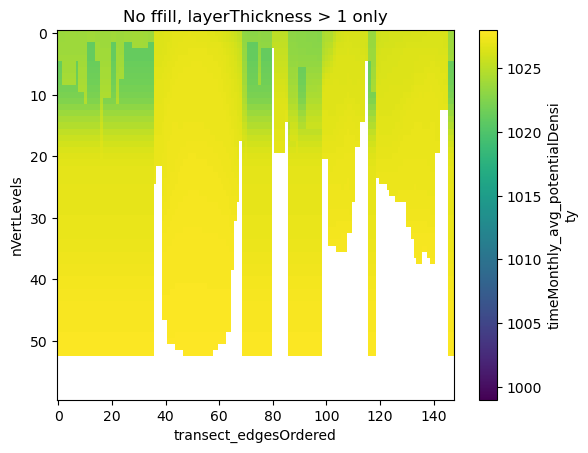

In [477]:
dss_transect_edges.timeMonthly_avg_potentialDensity.mean(dim=['xtime_startMonthly','TWO']).swap_dims({'nEdges':'transect_edgesOrdered'}).plot(y='nVertLevels',vmin=999,vmax=1028)
plt.gca().invert_yaxis()
plt.title('No ffill, layerThickness > 1 only')

In [478]:
# NO FFILL, NO LAYER THICKNESS MASK
# get only the cells on transect edges
xr_cellsOnTransectEdges = mps.n_to_xr_idx(mesh.cellsOnEdge.isel(nEdges = edges))
dss_transect_edges = dss.isel(nEdges = edges, nCells = xr_cellsOnTransectEdges)

# make a datavariable that holds the order of the nEdges in the transect
dss_transect_edges['transect_edgesOrdered'] = xr.DataArray(np.arange(0,edges.size),dims='nEdges')
dss_transect_edges = dss_transect_edges.assign_coords({'transect_edgesOrdered': dss_transect_edges.transect_edgesOrdered})

# we now have a dataset with cells and edges that are bordering the transect surrounding the mask

# make the potential density sit on edges by taking the mean of the potential density of the two cells adjacent to that edge
dss_transect_edges['timeMonthly_avg_potentialDensity_Edge'] = dss_transect_edges.timeMonthly_avg_potentialDensity.mean(dim='TWO')

# interpolate the potential density values onto nVertLevelsP1 coordinates
# create an xgcm grid
grid = Grid(dss_transect_edges, coords={'Z':{'center':'nVertLevels','outer':'nVertLevelsP1'}},periodic=False,autoparse_metadata=False)

# interpolate
# these values shouldn't exactly match nVertLevels valuse, right?
dss_transect_edges['timeMonthly_avg_potentialDensity_EdgeP1'] = grid.interp(dss_transect_edges.timeMonthly_avg_potentialDensity_Edge,'Z',boundary='extend')

Text(0.5, 1.0, 'Densities')

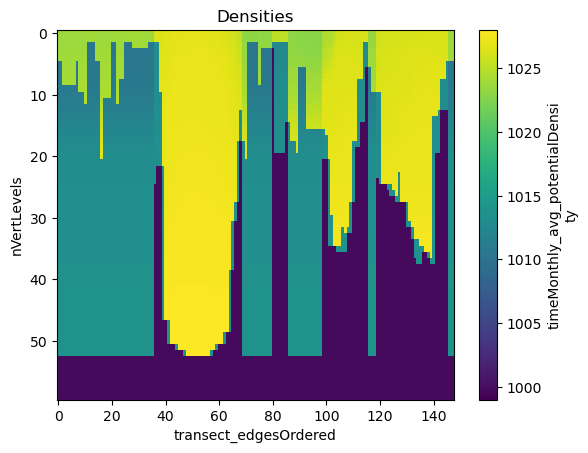

In [479]:
dss_transect_edges.timeMonthly_avg_potentialDensity.mean(dim=['xtime_startMonthly','TWO']).swap_dims({'nEdges':'transect_edgesOrdered'}).plot(y='nVertLevels',vmin=999,vmax=1028)
plt.gca().invert_yaxis()
plt.title('Densities')

Text(0.5, 1.0, 'Densities')

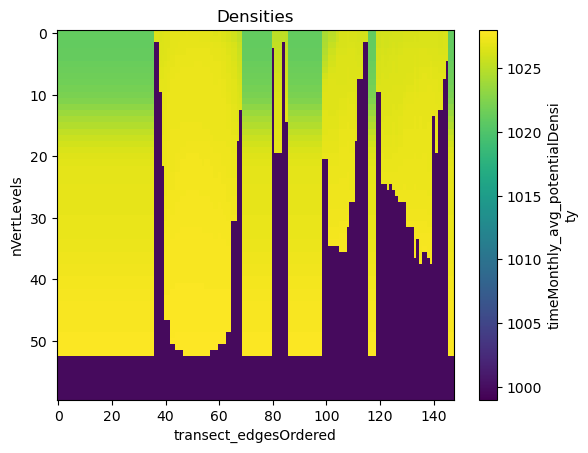

In [480]:
dss_transect_edges.timeMonthly_avg_potentialDensity.mean(dim='xtime_startMonthly').isel(TWO=1).swap_dims({'nEdges':'transect_edgesOrdered'}).plot(y='nVertLevels',vmin=999,vmax=1028)
plt.gca().invert_yaxis()
plt.title('Densities')

Text(0.5, 1.0, 'Densities')

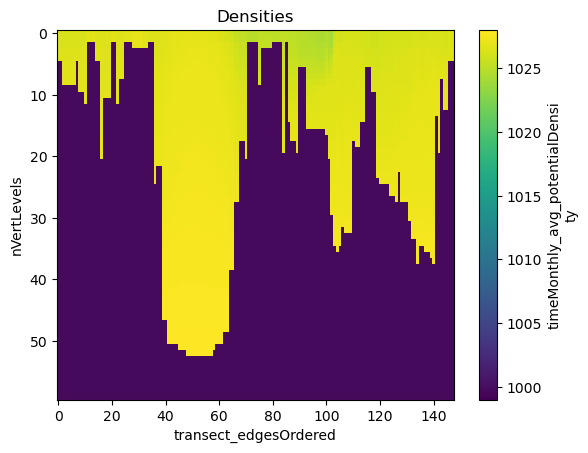

In [481]:
dss_transect_edges.timeMonthly_avg_potentialDensity.mean(dim='xtime_startMonthly').isel(TWO=0).swap_dims({'nEdges':'transect_edgesOrdered'}).plot(y='nVertLevels',vmin=999,vmax=1028)
plt.gca().invert_yaxis()
plt.title('Densities')

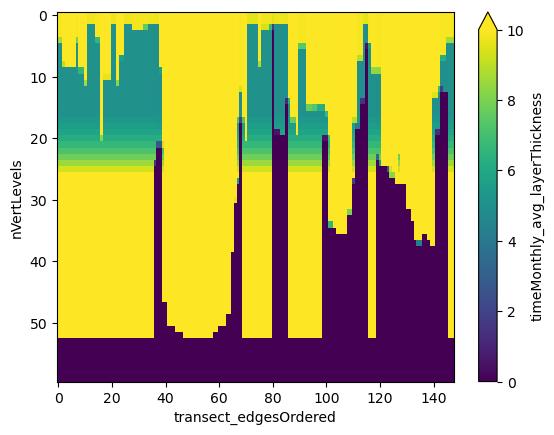

In [482]:
dss_transect_edges.timeMonthly_avg_layerThickness.mean(dim=['xtime_startMonthly','TWO']).swap_dims({'nEdges':'transect_edgesOrdered'}).plot(y='nVertLevels',vmax=10)
plt.gca().invert_yaxis()

Text(0.5, 1.0, 'TWO = 1')

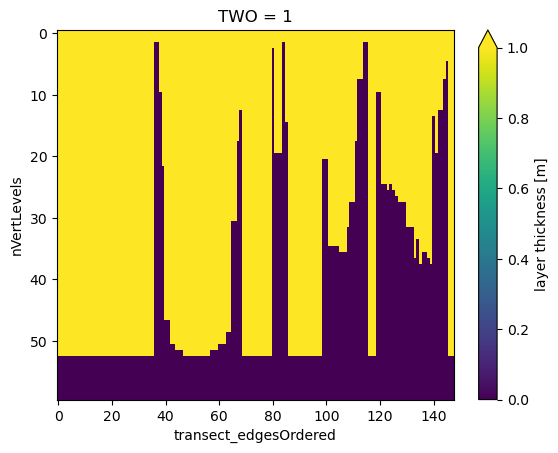

In [483]:
# NO FFILL, NO LAYER THICKNESS MASK: TWO=0
# get only the cells on transect edges
xr_cellsOnTransectEdges = mps.n_to_xr_idx(mesh.cellsOnEdge.isel(nEdges = edges))
dss_transect_edges = dss.isel(nEdges = edges, nCells = xr_cellsOnTransectEdges)

# make a datavariable that holds the order of the nEdges in the transect
dss_transect_edges['transect_edgesOrdered'] = xr.DataArray(np.arange(0,edges.size),dims='nEdges')
dss_transect_edges = dss_transect_edges.assign_coords({'transect_edgesOrdered': dss_transect_edges.transect_edgesOrdered})

dss_transect_edges.timeMonthly_avg_layerThickness.isel(TWO=1,xtime_startMonthly=0).swap_dims({'nEdges':'transect_edgesOrdered'}).plot(y='nVertLevels',vmax=1)
plt.gca().invert_yaxis()
plt.title('TWO = 1')

Text(0.5, 1.0, 'TWO = 1')

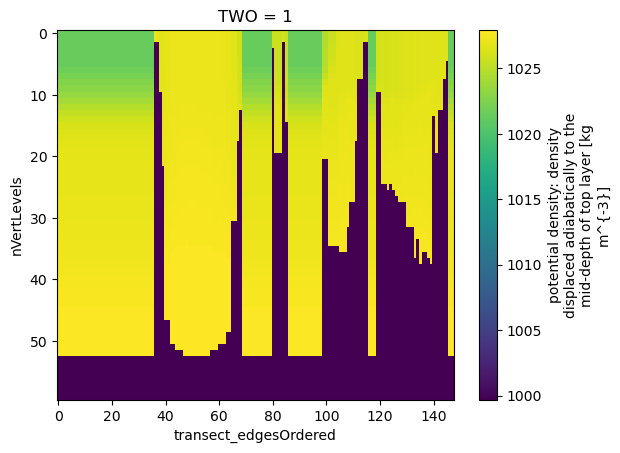

In [484]:
# NO FFILL, NO LAYER THICKNESS MASK: TWO=0
# get only the cells on transect edges
xr_cellsOnTransectEdges = mps.n_to_xr_idx(mesh.cellsOnEdge.isel(nEdges = edges))
dss_transect_edges = dss.isel(nEdges = edges, nCells = xr_cellsOnTransectEdges)

# make a datavariable that holds the order of the nEdges in the transect
dss_transect_edges['transect_edgesOrdered'] = xr.DataArray(np.arange(0,edges.size),dims='nEdges')
dss_transect_edges = dss_transect_edges.assign_coords({'transect_edgesOrdered': dss_transect_edges.transect_edgesOrdered})

dss_transect_edges.timeMonthly_avg_potentialDensity.isel(TWO=1,xtime_startMonthly=0).swap_dims({'nEdges':'transect_edgesOrdered'}).plot(y='nVertLevels')
plt.gca().invert_yaxis()
plt.title('TWO = 1')

Text(0.5, 1.0, 'TWO=0')

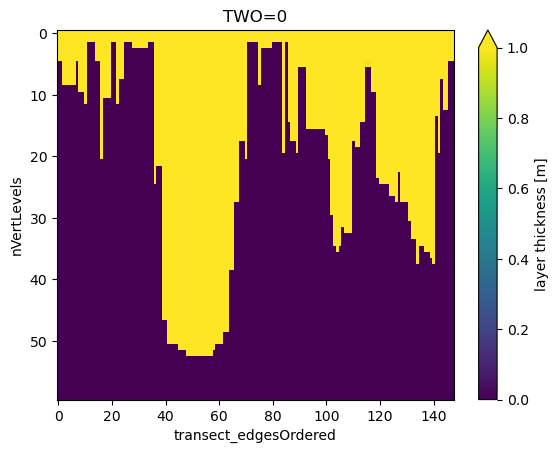

In [485]:
# NO FFILL, NO LAYER THICKNESS MASK: TWO=1
# get only the cells on transect edges
xr_cellsOnTransectEdges = mps.n_to_xr_idx(mesh.cellsOnEdge.isel(nEdges = edges))
dss_transect_edges = dss.isel(nEdges = edges, nCells = xr_cellsOnTransectEdges)

# make a datavariable that holds the order of the nEdges in the transect
dss_transect_edges['transect_edgesOrdered'] = xr.DataArray(np.arange(0,edges.size),dims='nEdges')
dss_transect_edges = dss_transect_edges.assign_coords({'transect_edgesOrdered': dss_transect_edges.transect_edgesOrdered})

dss_transect_edges.timeMonthly_avg_layerThickness.isel(TWO=0,xtime_startMonthly=0).swap_dims({'nEdges':'transect_edgesOrdered'}).plot(y='nVertLevels',vmax=1)
plt.gca().invert_yaxis()
plt.title('TWO=0')

Text(0.5, 1.0, 'TWO=0')

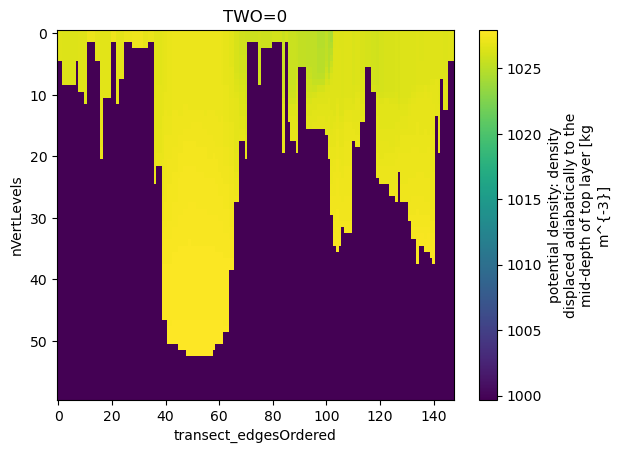

In [486]:
# NO FFILL, NO LAYER THICKNESS MASK: TWO=1
# get only the cells on transect edges
xr_cellsOnTransectEdges = mps.n_to_xr_idx(mesh.cellsOnEdge.isel(nEdges = edges))
dss_transect_edges = dss.isel(nEdges = edges, nCells = xr_cellsOnTransectEdges)

# make a datavariable that holds the order of the nEdges in the transect
dss_transect_edges['transect_edgesOrdered'] = xr.DataArray(np.arange(0,edges.size),dims='nEdges')
dss_transect_edges = dss_transect_edges.assign_coords({'transect_edgesOrdered': dss_transect_edges.transect_edgesOrdered})

dss_transect_edges.timeMonthly_avg_potentialDensity.isel(TWO=0,xtime_startMonthly=0).swap_dims({'nEdges':'transect_edgesOrdered'}).plot(y='nVertLevels')
plt.gca().invert_yaxis()
plt.title('TWO=0')

In [487]:
dss_transect_edges.timeMonthly_avg_layerThickness

<xarray.DataArray 'timeMonthly_avg_layerThickness' (xtime_startMonthly: 12,
                                                    nEdges: 148, TWO: 2,
                                                    nVertLevels: 60)> Size: 852kB
array([[[[ 9.818573 ,  9.81874  ,  9.81874  , ...,  0.       ,
           0.       ,  0.       ],
         [ 9.999872 ,  9.999835 ,  9.999835 , ...,  0.       ,
           0.       ,  0.       ]],

        [[ 9.818573 ,  9.81874  ,  9.81874  , ...,  0.       ,
           0.       ,  0.       ],
         [ 9.999872 ,  9.999835 ,  9.999835 , ...,  0.       ,
           0.       ,  0.       ]],

        [[ 9.909999 ,  9.90995  ,  9.90995  , ...,  0.       ,
           0.       ,  0.       ],
         [ 9.999872 ,  9.999835 ,  9.999835 , ...,  0.       ,
           0.       ,  0.       ]],

        ...,

        [[ 9.938466 ,  9.938387 ,  9.938387 , ...,  0.       ,
           0.       ,  0.       ],
         [ 9.818573 ,  9.81874  ,  9.81874  , ...,  0.       ,
...
         [10.000566 , 10.000539 , 10.000539 , ...,  0.       ,
           0.       ,  0.       ]],

        ...,

        [[ 9.937792 ,  9.937786 ,  9.937786 , ...,  0.       ,
           0.       ,  0.       ],
         [ 9.83151  ,  9.831498 ,  9.831498 , ...,  0.       ,
           0.       ,  0.       ]],

        [[ 9.83151  ,  9.831498 ,  9.831498 , ...,  0.       ,
           0.       ,  0.       ],
         [10.000566 , 10.000539 , 10.000539 , ...,  0.       ,
           0.       ,  0.       ]],

        [[ 9.83151  ,  9.831498 ,  9.831498 , ...,  0.       ,
           0.       ,  0.       ],
         [10.000566 , 10.000539 , 10.000539 , ...,  0.       ,
           0.       ,  0.       ]]]],
      shape=(12, 148, 2, 60), dtype=float32)
Coordinates:
  * xtime_startMonthly     (xtime_startMonthly) |S64 768B b'0060-01-01_00:30:...
    nCells                 (nEdges, TWO) int64 2kB 202047 236852 ... 236852
  * nEdges                 (nEdges) int64 1kB 17579 539876 ... 125371 17579
  * nVertLevels            (nVertLevels) int64 480B 0 1 2 3 4 ... 55 56 57 58 59
    transect_edgesOrdered  (nEdges) int64 1kB 0 1 2 3 4 ... 143 144 145 146 147
Dimensions without coordinates: TWO
Attributes:
    units:      m
    long_name:  layer thickness

In [509]:
xr_cellsOnTransectEdges

<xarray.DataArray 'cellsOnEdge' (nEdges: 148, TWO: 2)> Size: 1kB
array([[202047,     -1],
       [202047,     -1],
       [ 70611,     -1],
       [ 69283,     -1],
       [ 69283,     -1],
       [ 69283,     -1],
       [ 69283,     -1],
       [ 63299,     -1],
       [ 63298,     -1],
       [ 63298,     -1],
       [136135,     -1],
       [128775,     -1],
       [128775,     -1],
       [128775,     -1],
       [ 58948,     -1],
       [ 58948,     -1],
       [ 24737,     -1],
       [ 20891,     -1],
       [ 20891,     -1],
       [ 20891,     -1],
...
       [ 39824,  41311],
       [ 39824,  46588],
       [ 39824, 126557],
       [ 39822, 126557],
       [122329, 126557],
       [122329, 126555],
       [ 77740, 122329],
       [ 40552,  77740],
       [ 40552,  60463],
       [ 59671,  60463],
       [ 60463,  79928],
       [ 79928,  89602],
       [ 89602, 109487],
       [109487, 118207],
       [118207, 193757],
       [173149, 193757],
       [165081, 173149],
       [165081, 202047],
       [202047,     -1],
       [202047,     -1]], dtype=int32)
Dimensions without coordinates: nEdges, TWO

In [533]:
xr_cellsOnTransectEdges_landNaNs = xr_cellsOnTransectEdges.where(xr_cellsOnTransectEdges >= 0)

In [ ]:
# get the cells that are on transect edges AND do not border land

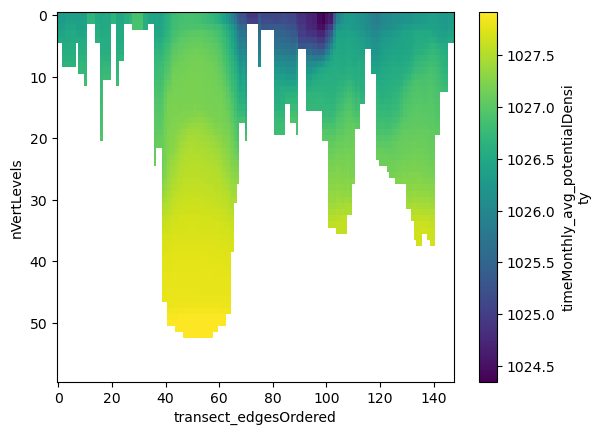

In [552]:
# remove cells that border land
dss_transect_edges_landNaNs = dss.isel(nEdges = edges, nCells = xr_cellsOnTransectEdges).where(xr_cellsOnTransectEdges >= 0)

# remove cells that are given low datavariable values to represent land
dss_transect_edges_NaNs = dss_transect_edges.where((dss_transect_edges.timeMonthly_avg_layerThickness != np.nan) & (dss_transect_edges.timeMonthly_avg_layerThickness > 0))

# plot something
dss_transect_edges_NaNs.timeMonthly_avg_potentialDensity.mean(dim=['xtime_startMonthly','TWO']).swap_dims({'nEdges':'transect_edgesOrdered'}).plot(y='nVertLevels')
plt.gca().invert_yaxis()

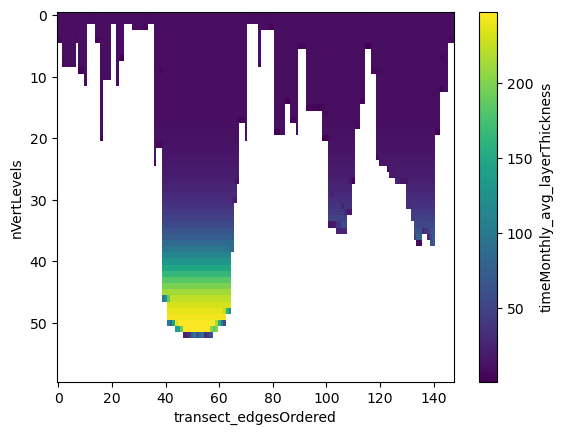

In [553]:
dss_transect_edges_NaNs.timeMonthly_avg_layerThickness.mean(dim=['xtime_startMonthly','TWO']).swap_dims({'nEdges':'transect_edgesOrdered'}).plot(y='nVertLevels')
plt.gca().invert_yaxis()

In [510]:
# get only the cells on transect edges
xr_cellsOnTransectEdges = mps.n_to_xr_idx(mesh.cellsOnEdge.isel(nEdges = edges))
dss_transect_edges = dss.isel(nEdges = edges, nCells = xr_cellsOnTransectEdges).where(xr_cellsOnTransectEdges >= 0)

# make a datavariable that holds the order of the nEdges in the transect
dss_transect_edges['transect_edgesOrdered'] = xr.DataArray(np.arange(0,edges.size),dims='nEdges')
dss_transect_edges = dss_transect_edges.assign_coords({'transect_edgesOrdered': dss_transect_edges.transect_edgesOrdered})

# we now have a dataset with cells and edges that are bordering the transect surrounding the mask

# # modify the potential density to fill all land values with the potential density of the last ocean cell
# thickLayers_ocean = dss_transect_edges.timeMonthly_avg_potentialDensity > 1000
# dss_transect_edges['timeMonthly_avg_potentialDensity'] = dss_transect_edges.timeMonthly_avg_potentialDensity.where(thickLayers_ocean).ffill(dim='nVertLevels',limit=None)


Text(0.5, 0.98, 'layerThickness between 2 grid cells')

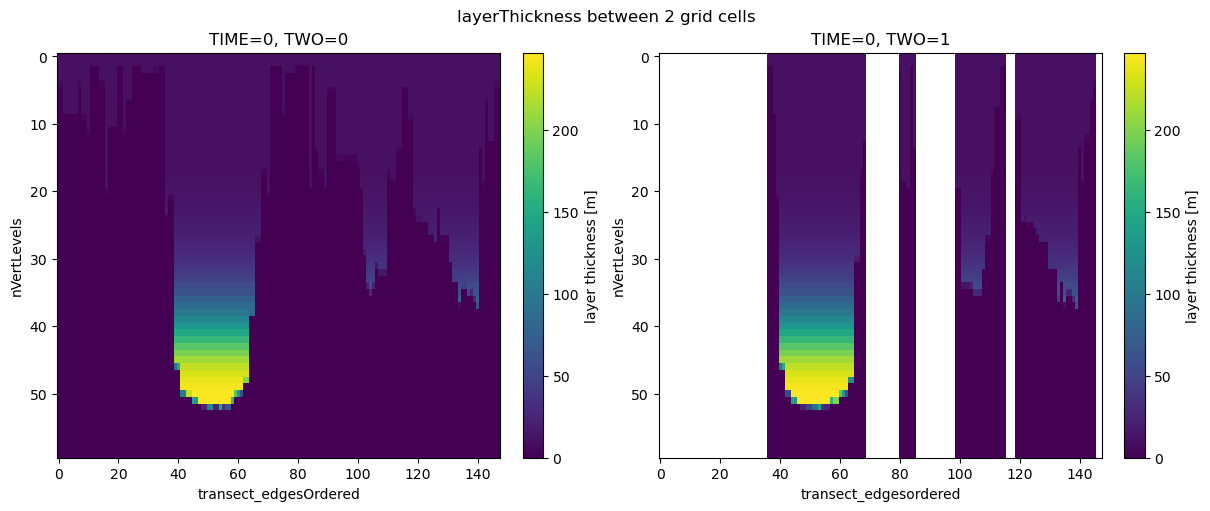

In [513]:
fig,ax = plt.subplots(nrows=1,ncols=2,constrained_layout=True,figsize=(12,5))
dss_transect_edges.timeMonthly_avg_layerThickness.isel(xtime_startMonthly=0,TWO=0).swap_dims({'nEdges':'transect_edgesOrdered'}).plot(ax=ax[0],y='nVertLevels',vmin=0)
ax[0].invert_yaxis()
ax[0].set_title('TIME=0, TWO=0')

# dss_transect_edges.timeMonthly_avg_layerThickness.isel(xtime_startMonthly=0,TWO=1).swap_dims({'nEdges':'transect_edgesordered'}).plot(ax=ax[1],y='nVertLevels',vmin=0)

dss_transect_edges.timeMonthly_avg_layerThickness.isel(xtime_startMonthly=0,TWO=1).swap_dims({'nEdges':'transect_edgesordered'}).plot(ax=ax[1],y='nVertLevels',vmin=0)

ax[1].invert_yaxis()
ax[1].set_title('TIME=0, TWO=1')
fig.suptitle('layerThickness between 2 grid cells')

In [527]:
dss_transect_edges.timeMonthly_avg_potentialDensity 

<xarray.DataArray 'timeMonthly_avg_potentialDensity' ()> Size: 8B
array(999.69519043)

In [526]:
dss.timeMonthly_avg_potentialDensity

<xarray.DataArray 'timeMonthly_avg_potentialDensity' ()> Size: 8B
array(994.91815186)

Text(0.5, 0.98, 'potentialDensity between 2 grid cells')

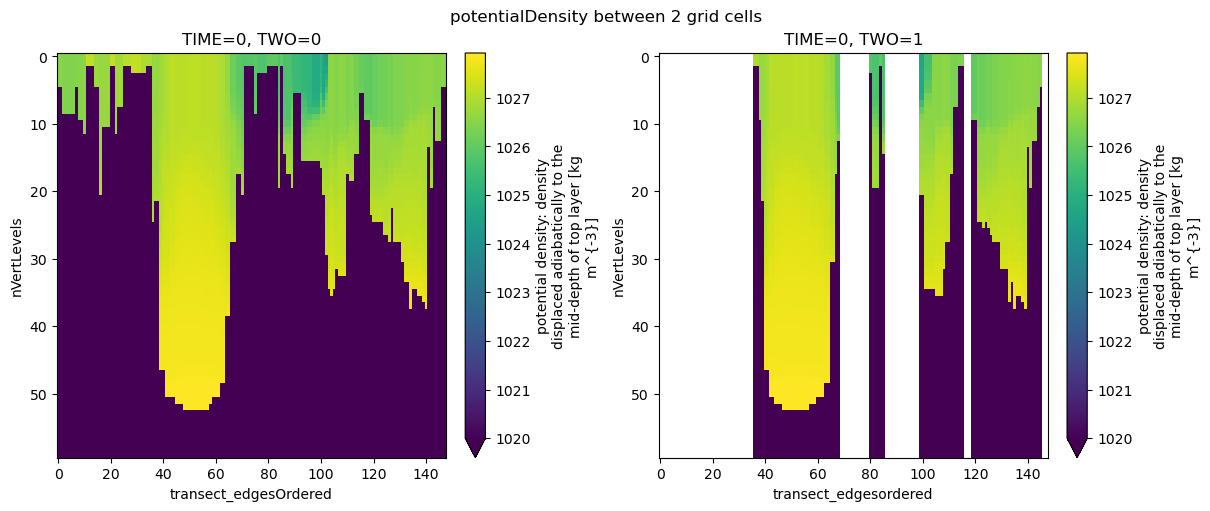

In [514]:
fig,ax = plt.subplots(nrows=1,ncols=2,constrained_layout=True,figsize=(12,5))
dss_transect_edges.timeMonthly_avg_potentialDensity.isel(xtime_startMonthly=0,TWO=0).swap_dims({'nEdges':'transect_edgesOrdered'}).plot(ax=ax[0],y='nVertLevels',vmin=1020)
ax[0].invert_yaxis()
ax[0].set_title('TIME=0, TWO=0')

dss_transect_edges.timeMonthly_avg_potentialDensity.isel(xtime_startMonthly=0,TWO=1).swap_dims({'nEdges':'transect_edgesordered'}).plot(ax=ax[1],y='nVertLevels',vmin=1020)
ax[1].invert_yaxis()
ax[1].set_title('TIME=0, TWO=1')
fig.suptitle('potentialDensity between 2 grid cells')

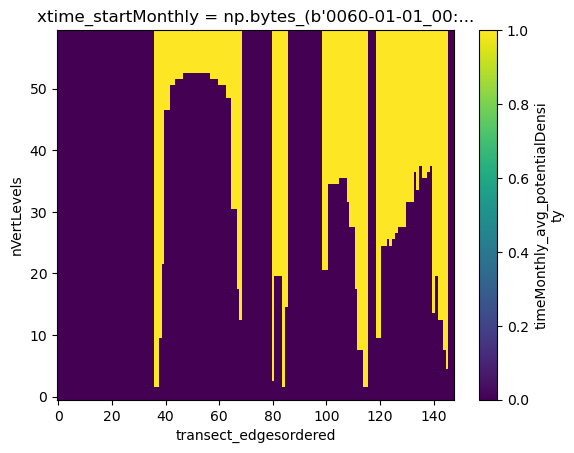

In [528]:
(dss_transect_edges.timeMonthly_avg_potentialDensity.isel(xtime_startMonthly=0,TWO=1).swap_dims({'nEdges':'transect_edgesordered'}).where( layer_thickness > 0 ) ).plot(y='nVertLevels')

In [491]:
dss_transect_edges.transect_edgesOrdered

<xarray.DataArray 'transect_edgesOrdered' (nEdges: 148)> Size: 1kB
array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147])
Coordinates:
  * nEdges                 (nEdges) int64 1kB 17579 539876 ... 125371 17579
    transect_edgesOrdered  (nEdges) int64 1kB 0 1 2 3 4 ... 143 144 145 146 147

In [492]:
mesh.cellsOnEdge.min()

<xarray.DataArray 'cellsOnEdge' ()> Size: 4B
array(0, dtype=int32)

In [493]:
mesh.indexToEdgeID#.min()

<xarray.DataArray 'indexToEdgeID' (nEdges: 719506)> Size: 3MB
[719506 values with dtype=int32]
Dimensions without coordinates: nEdges
Attributes:
    units:      unitless
    long_name:  List of global edge IDs.

In [495]:
# get cellsOnEdge of edges of transect
n_mesh_cellsOnTransectEdges = mesh.cellsOnEdge.isel(nEdges = dss_transect_edges.nEdges)
xr_mesh_cellsOnTransectEdges = mps.n_to_xr_idx(n_mesh_cellsOnTransectEdges)

# of theses cells, identify the cells that are actually land


In [496]:
dss_transect_edges

<xarray.Dataset> Size: 2MB
Dimensions:                           (xtime_startMonthly: 12, nEdges: 148,
                                       nVertLevels: 60, TWO: 2,
                                       nVertLevelsP1: 61)
Coordinates:
  * xtime_startMonthly                (xtime_startMonthly) |S64 768B b'0060-0...
    nCells                            (nEdges, TWO) int64 2kB 202047 ... 236852
  * nEdges                            (nEdges) int64 1kB 17579 539876 ... 17579
  * nVertLevels                       (nVertLevels) int64 480B 0 1 2 ... 58 59
  * nVertLevelsP1                     (nVertLevelsP1) int64 488B 0 1 2 ... 59 60
    transect_edgesOrdered             (nEdges) int64 1kB 0 1 2 3 ... 145 146 147
Dimensions without coordinates: TWO
Data variables:
    timeMonthly_avg_normalVelocity    (xtime_startMonthly, nEdges, nVertLevels) float32 426kB ...
    timeMonthly_avg_potentialDensity  (xtime_startMonthly, nEdges, TWO, nVertLevels) float32 852kB ...
    timeMonthly_avg_layerThickness    (xtime_startMonthly, nEdges, TWO, nVertLevels) float32 852kB ...
    maxLevelCell                      (nEdges, TWO) int32 1kB ...
Attributes: (12/722)
    on_a_sphere:                                                  YES
    sphere_radius:                                                6.371229e+06
    model_name:                                                   mpas
    core_name:                                                    ocean
    history:                                                      mpirun -n 6...
    source:                                                       MPAS
    ...                                                           ...
    config_AM_harmonicAnalysis_use_K2:                            YES
    config_AM_harmonicAnalysis_use_K1:                            YES
    config_AM_harmonicAnalysis_use_O1:                            YES
    config_AM_harmonicAnalysis_use_Q1:                            YES
    config_AM_harmonicAnalysis_use_P1:                            YES
    file_id:                                                      s27a3cssmx

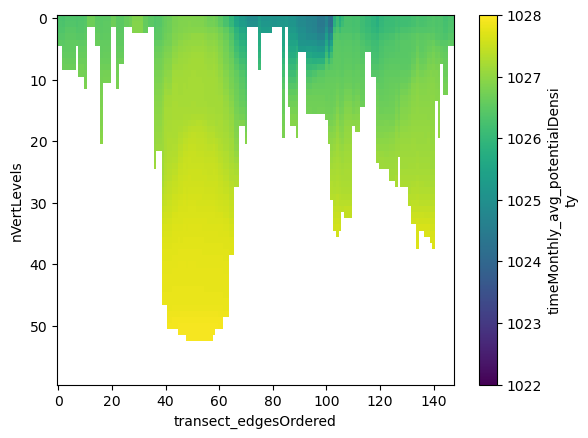

In [497]:
# find cells on land
# dss_transect_edges.nCells are in xr indices
dss_transect_edges.timeMonthly_avg_potentialDensity.where(dss_transect_edges.timeMonthly_avg_potentialDensity > 1000).mean(dim='xtime_startMonthly').isel(TWO=0).swap_dims({'nEdges':'transect_edgesOrdered'}).plot(y='nVertLevels',
                                                                                                                                                                                                    vmin=1022,vmax=1028)
plt.gca().invert_yaxis()
#.mean(dim=['xtime_startMonthly','TWO']).swap_dims({'nEdges':'transect_edgesOrdered'}).plot()

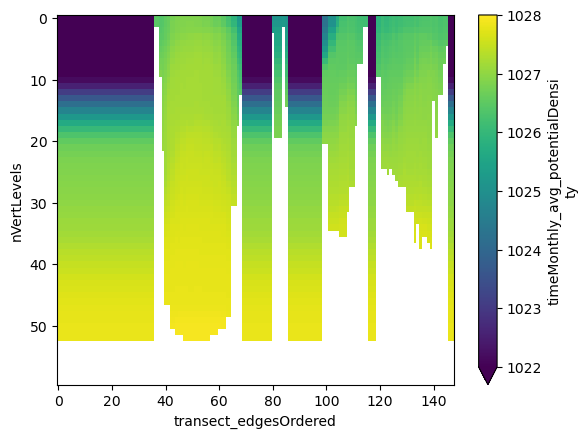

In [498]:
# find cells on land
# dss_transect_edges.nCells are in xr indices
dss_transect_edges.timeMonthly_avg_potentialDensity.where(dss_transect_edges.timeMonthly_avg_potentialDensity > 1000).mean(dim='xtime_startMonthly').isel(TWO=1).swap_dims({'nEdges':'transect_edgesOrdered'}).plot(y='nVertLevels',
                                                                                                                                                                                                         vmin=1022,vmax=1028)
plt.gca().invert_yaxis()
#.mean(dim=['xtime_startMonthly','TWO']).swap_dims({'nEdges':'transect_edgesOrdered'}).plot()

Text(0.5, 1.0, 'time mean, TWO=1')

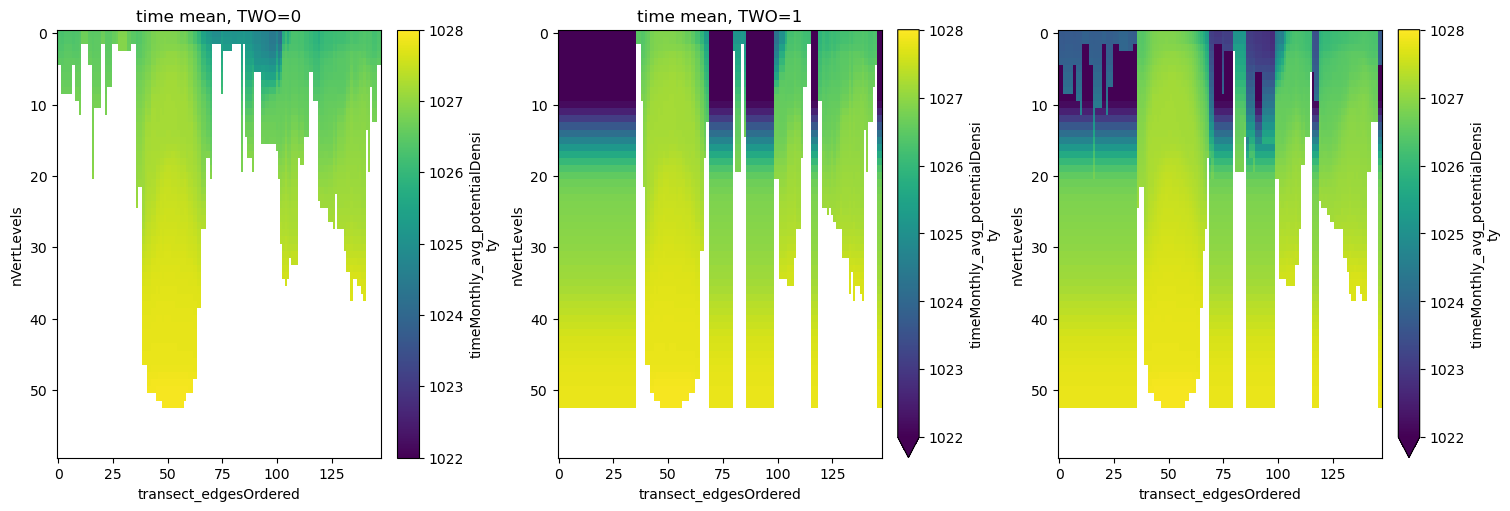

In [508]:
fig,ax = plt.subplots(nrows=1,ncols=3,constrained_layout=True,figsize=(15,5))

dss_transect_edges.timeMonthly_avg_potentialDensity.where(dss_transect_edges.timeMonthly_avg_potentialDensity > 1000).mean(dim='xtime_startMonthly').isel(TWO=0).swap_dims({'nEdges':'transect_edgesOrdered'}).plot(y='nVertLevels',
                                                                                                                                                                                                    vmin=1022,vmax=1028,ax=ax[0])

dss_transect_edges.timeMonthly_avg_potentialDensity.where(dss_transect_edges.timeMonthly_avg_potentialDensity > 1000).mean(dim='xtime_startMonthly').isel(TWO=1).swap_dims({'nEdges':'transect_edgesOrdered'}).plot(y='nVertLevels',
                                                                                                                                                                                                         vmin=1022,vmax=1028,ax=ax[1])

dss_transect_edges.timeMonthly_avg_potentialDensity.where(dss_transect_edges.timeMonthly_avg_potentialDensity > 1000).mean(dim=['xtime_startMonthly','TWO']).swap_dims({'nEdges':'transect_edgesOrdered'}).plot(y='nVertLevels',
                                                                                                                                                                                                         vmin=1022,vmax=1028,ax=ax[2])

ax[0].invert_yaxis()
ax[1].invert_yaxis()
ax[2].invert_yaxis()

ax[0].set_title('time mean, TWO=0')
ax[1].set_title('time mean, TWO=1')

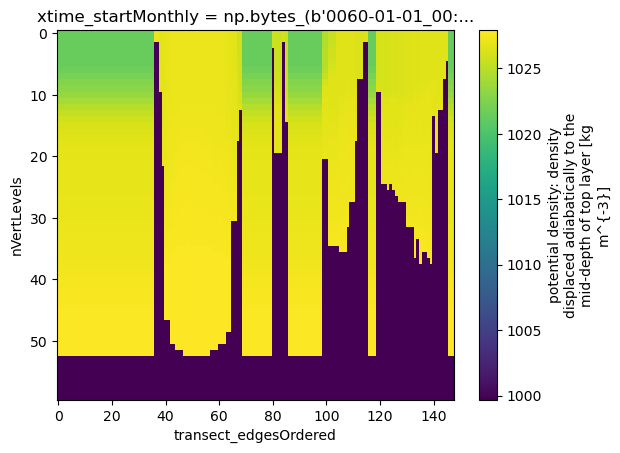

In [500]:
dss_transect_edges.timeMonthly_avg_potentialDensity.isel(xtime_startMonthly=0,TWO=1).swap_dims({'nEdges':'transect_edgesOrdered'}).plot(y='nVertLevels')
plt.gca().invert_yaxis()

In [501]:
oceanocean_cells_raw = np.unique(xr_transect_cellsOnOceanEdges.transect_edgesOrdered.where((xr_transect_cellsOnOceanEdges.isel(TWO=0)>0) & (xr_transect_cellsOnOceanEdges.isel(TWO=1)>0)))

In [502]:
oceanocean_cells = np.int32(oceanocean_cells_raw[~np.isnan(oceanocean_cells_raw)])
oceanocean_cells

landocean_cells = np.setxor1d(np.array(dss_transect_edges.transect_edgesOrdered), oceanocean_cells)

In [503]:
np.unique(dss_transect_edges.timeMonthly_avg_layerThickness.isel(xtime_startMonthly=0,nVertLevels=0))

array([9.40069  , 9.41604  , 9.511092 , 9.515953 , 9.528431 , 9.535035 ,
       9.536601 , 9.541401 , 9.542378 , 9.571994 , 9.588341 , 9.6314335,
       9.6454935, 9.656863 , 9.740497 , 9.786472 , 9.7938595, 9.805881 ,
       9.818573 , 9.822216 , 9.849912 , 9.8800745, 9.881583 , 9.890709 ,
       9.909757 , 9.909999 , 9.91006  , 9.911051 , 9.915074 , 9.922427 ,
       9.923703 , 9.927711 , 9.92806  , 9.928299 , 9.929227 , 9.9313965,
       9.933105 , 9.933997 , 9.934329 , 9.934602 , 9.935485 , 9.936047 ,
       9.937513 , 9.938466 , 9.942301 , 9.944216 , 9.944262 , 9.944826 ,
       9.9450245, 9.946731 , 9.950611 , 9.953126 , 9.953955 , 9.954106 ,
       9.954153 , 9.955054 , 9.955821 , 9.956763 , 9.957089 , 9.957244 ,
       9.957696 , 9.960045 , 9.96006  , 9.960087 , 9.962346 , 9.962551 ,
       9.963178 , 9.967677 , 9.968779 , 9.969365 , 9.969985 , 9.971604 ,
       9.971867 , 9.973782 , 9.975578 , 9.977015 , 9.977583 , 9.977762 ,
       9.978907 , 9.978988 , 9.980967 , 9.982785 , 

In [ ]:
xr_cells_inside

In [ ]:
dss_transect_edges.timeMonthly_avg_layerThickness.swap_dims({'nEdges':'transect_edgesOrdered'}).isel(transect_edgesOrdered = oceanocean_cells).mean(dim='TWO')

In [ ]:
dss_transect_edges.timeMonthly_avg_layerThickness.swap_dims({'nEdges':'transect_edgesOrdered'}).isel(transect_edgesOrdered = oceanocean_cells).mean(dim='TWO')

In [ ]:
dss_transect_edges.timeMonthly_avg_layerThickness.swap_dims({'nEdges':'transect_edgesOrdered'}).isel(transect_edgesOrdered = oceanocean_cells).mean(dim='TWO').mean(dim='xtime_startMonthly').plot(y='nVertLevels')
plt.gca().invert_yaxis()

In [ ]:
# get only the cells on transect edges
xr_cellsOnTransectEdges = mps.n_to_xr_idx(mesh.cellsOnEdge.isel(nEdges = edges))
dss_transect_edges_noffill = dss.isel(nEdges = edges, nCells = xr_cellsOnTransectEdges)

dss_transect_edges_no_ffill_NaNs = dss_transect_edges_noffill
dss_transect_edges_no_ffill_NaNs.timeMonthly_avg_potentialDensity.mean(dim=['xtime_startMonthly','TWO']).swap_dims({'nEdges':'transect_edgesOrdered'}).plot(y='nVertLevels',vmin=999,vmax=1028)
plt.gca().invert_yaxis()
plt.title('No ffill, all densities')

In [ ]:
dss_transect_edges_no_ffill_NaNs.timeMonthly_avg_potentialDensity

In [ ]:
dss_transect_edges_no_ffill_NaNs

In [ ]:
dss_transect_edges_thickLayers = dss_transect_edges_no_ffill_NaNs.timeMonthly_avg_layerThickness > 5
dss_transect_edges_no_ffill_NaNs.timeMonthly_avg_layerThickness.where(dss_transect_edges_thickLayers).mean(['xtime_startMonthly','TWO'])

In [ ]:
def fillna_below(ds, data_var):
    for i in range(0,len(ds.nCells)): # for each coord in the dataset

        # define the slice of vertical levels that are nans
        nVertLevels_nans = slice(np.int32(ds.maxLevelCell[i]),None)

        # define the max vertical level
        maxLevelCell = np.int32(ds.maxLevelCell[i]) - 1

        # make the nan cells = the datavariable at the max vertical level
        ds[data_var].loc[dict(nCells = np.int32(ds.nCells[i]), nVertLevels = nVertLevels_nans)] = ds[data_var].loc[dict(nCells = np.int32(ds.nCells[i]), nVertLevels = maxLevelCell)]
    return ds

In [ ]:
dss_transect_edges_no_ffill_NaNs_nCells = dss_transect_edges_no_ffill_NaNs.stack(nEdgesTWO = ('nEdges','TWO')).swap_dims({'nEdgesTWO':'nCells'})

In [ ]:
ds_transect_edges_fillna_below = fillna_below(dss_transect_edges_no_ffill_NaNs_nCells, 'timeMonthly_avg_potentialDensity')

In [ ]:
ds_transect_edges_fillna_below

In [ ]:
ds_transect_edges_fillna_below_unswapped = ds_transect_edges_fillna_below.timeMonthly_avg_potentialDensity#.mean(dim='xtime_startMonthly')#.swap_dims({'nCells':'nEdgesTWO'})
ds_transect_edges_fillna_below_unswapped

In [ ]:
def fillna_below(ds, data_var):
    for i in range(0,len(ds.nCells)): # for each coord in the dataset

        # define the slice of vertical levels that are nans
        nVertLevels_nans = slice(np.int32(ds.maxLevelCell[i]),None)

        # define the max vertical level
        maxLevelCell = np.int32(ds.maxLevelCell[i]) - 1

        # make the nan cells = the datavariable at the max vertical level
        ds[data_var].loc[dict(nCells = np.int32(ds.nCells[i]), nVertLevels = nVertLevels_nans)] = ds[data_var].loc[dict(nCells = np.int32(ds.nCells[i]), nVertLevels = maxLevelCell)]

    return ds

In [ ]:
# # get only the cells on transect edges
# xr_cellsOnTransectEdges = mps.n_to_xr_idx(mesh.cellsOnEdge.isel(nEdges = edges))
# dss_transect_edges = dss.isel(nEdges = edges, nCells = xr_cellsOnTransectEdges)

# # make a datavariable that holds the order of the nEdges in the transect
# dss_transect_edges['transect_edgesOrdered'] = xr.DataArray(np.arange(0,edges.size),dims='nEdges')
# dss_transect_edges

# # we now have a dataset with cells and edges that are bordering the transect surrounding the mask

# # modify the potential density to fill all land values with the potential density of the last ocean cell
# potentialDensity_ocean = dss_transect_edges.timeMonthly_avg_potentialDensity > 1000
# dss_transect_edges['timeMonthly_avg_potentialDensity'] = dss_transect_edges.timeMonthly_avg_potentialDensity.where(potentialDensity_ocean).ffill(dim='nVertLevels',limit=None)

# # make the potential density sit on edges by taking the mean of the potential density of the two cells adjacent to that edge
# dss_transect_edges['timeMonthly_avg_potentialDensity_Edge'] = dss_transect_edges.timeMonthly_avg_potentialDensity.mean(dim='TWO')

# # interpolate the potential density values onto nVertLevelsP1 coordinates
# # create an xgcm grid
# grid = Grid(dss_transect_edges, coords={'Z':{'center':'nVertLevels','outer':'nVertLevelsP1'}},periodic=False,autoparse_metadata=False)

# # interpolate
# # these values shouldn't exactly match nVertLevels valuse, right?
# dss_transect_edges['timeMonthly_avg_potentialDensity_EdgeP1'] = grid.interp(dss_transect_edges.timeMonthly_avg_potentialDensity_Edge,'Z',boundary='extend')

In [ ]:
dss_transect_edges = dss_transect_edges.assign_coords({'transect_edgesOrdered': dss_transect_edges.transect_edgesOrdered})
dss_transect_edges

In [ ]:
plt.pcolor(dss_transect_edges.timeMonthly_avg_potentialDensity_Edge.isel(xtime_startMonthly=0))
plt.colorbar()

# calculate transport

## calculate velocity into mask

In [ ]:
def calculate_velo_into_mask(ds, mesh, mask):
    ds['veloIntoMask'] = ds.timeMonthly_avg_normalVelocity * 0
    
    # .isel the mesh to only get the sorted edges on the transect (identified already in dss_transect_edges
    mesh_transect_edges = mesh.isel(nEdges = dss_transect_edges.nEdges)
    
    # find transect edges that border land using the cellsOnEdge variable from the mesh
    xr_transect_edgesOnLand_TWO0 = mesh_transect_edges.nEdges.where(np.isin(mesh_transect_edges.cellsOnEdge.isel(TWO=0),0))
    xr_transect_edgesOnLand_TWO1 = mesh_transect_edges.nEdges.where(np.isin(mesh_transect_edges.cellsOnEdge.isel(TWO=1),0))
    xr_transect_edgesOnLand = np.union1d(xr_transect_edgesOnLand_TWO0, xr_transect_edgesOnLand_TWO1)
    
    # find transect edges that border ocean (all transect edges NOT bordering land)
    xr_transect_edgesOnOcean = np.setxor1d(edges, xr_transect_edgesOnLand)
    
    # find the cells that lie on the transect open ocean edges
    n_transect_cellsOnOceanEdges = mesh_transect_edges.cellsOnEdge
    xr_transect_cellsOnOceanEdges = mps.n_to_xr_idx(n_transect_cellsOnOceanEdges)
    
    # select all the cells inside the mask
    xr_cells_inside, ignore_xr_edges_inside, ignore_xr_vertices_inside = mps.xr_inside_mask_info(mesh,mask)
    
    
    # determine if the normal velocity points into or out of the mask 
    for i in range(0,len(xr_transect_cellsOnOceanEdges)):
        for j in range(0,len(ds.xtime_startMonthly)):
            cellsOnSelectedEdge = xr_transect_cellsOnOceanEdges.isel(nEdges = i)
            selectedEdge = np.int32(mesh_transect_edges.nEdges.isel(nEdges = i))
            selectedMonth = ds.xtime_startMonthly.isel(xtime_startMonthly=j)
    
            if cellsOnSelectedEdge.isel(TWO=0).isin(xr_cells_inside): # if A is inside the mask
                ds.veloIntoMask.loc[dict(xtime_startMonthly = selectedMonth, nEdges = selectedEdge)] = ds.timeMonthly_avg_normalVelocity.loc[dict(xtime_startMonthly = selectedMonth, 
                                                                                                                                                         nEdges = selectedEdge)] * -1
    
            elif cellsOnSelectedEdge.isel(TWO=1).isin(xr_cells_inside): # if B is inside the mask
                ds.veloIntoMask.loc[dict(xtime_startMonthly = selectedMonth, nEdges = selectedEdge)] = ds.timeMonthly_avg_normalVelocity.loc[dict(xtime_startMonthly = selectedMonth, 
                                                                                                                                                         nEdges = selectedEdge)] * 1

    return ds, mesh_transect_edges, xr_transect_cellsOnOceanEdges

In [ ]:
dss_transect_edges_vIM, mesh_transect_edges, xr_transect_cellsOnOceanEdges = calculate_velo_into_mask(dss_transect_edges, mesh, mask)

In [ ]:
plt.pcolor(dss_transect_edges_vIM.veloIntoMask.isel(xtime_startMonthly=0))

## calculate the cross-sectional area of the grid cell

In [ ]:
# calculate the area of the edge-layerThickness plane that the normal velocity moves through
# interpolate layer thickness onto nEdges
dss_transect_edges_vIM['timeMonthly_avg_layerThickness_Edge'] = dss_transect_edges_vIM.timeMonthly_avg_layerThickness.mean(dim='TWO')

# get the edge length for all edges in transect
mesh_transect_edges_dv = mesh_transect_edges.dvEdge

# calculate the cross-sectional area of the transect by multiplying the layer-thickness of the edge by the length of the edge
transect_area = dss_transect_edges_vIM.timeMonthly_avg_layerThickness_Edge * mesh_transect_edges_dv

## calculate transport into the mask

In [ ]:
transport = transect_area * dss_transect_edges_vIM.veloIntoMask / 10**6
dss_transect_edges_vIM['transportIntoMask_Sv'] = transport

In [ ]:
plt.pcolor(dss_transect_edges_vIM.transportIntoMask_Sv.isel(xtime_startMonthly = 0))
plt.colorbar()

# Since we want to look at transport per density class, we need to create density bins

## set up potential density so that it rests on nEdges and nVertLevelsP1

In [ ]:
# take the mean of the potential density of the two cells bordering the transect edge to place potential density on the nEdge
dss_transect_edges_vIM['timeMonthly_avg_potentialDensity_Edge'] = dss_transect_edges_vIM.timeMonthly_avg_potentialDensity.mean(dim='TWO')

# interpolate the timeMonthly_avg_potentialDensity_Edge values in the vertical direction (place onto nVertLevelsP1)
# create an xgcm grid
grid = Grid(dss_transect_edges_vIM, coords={'Z':{'center':'nVertLevels','outer':'nVertLevelsP1'}},periodic=False, autoparse_metadata=False)

# interpolate potential density in the vertical direction
dss_transect_edges_vIM['timeMonthly_avg_potentialDensity_Edge_P1'] = grid.interp(dss_transect_edges_vIM.timeMonthly_avg_potentialDensity_Edge,
                                                                                 'Z', boundary='extend')

In [ ]:
plt.pcolor(dss_transect_edges_vIM.timeMonthly_avg_potentialDensity_Edge_P1.isel(xtime_startMonthly=0))
plt.colorbar()

In [ ]:
print('min potential density: ', dss_transect_edges_vIM.timeMonthly_avg_potentialDensity_Edge_P1.min().values)
print('max potential density: ', dss_transect_edges_vIM.timeMonthly_avg_potentialDensity_Edge_P1.max().values)

In [ ]:
dss_transect_edges_vIM.transportIntoMask_Sv.sum()

## use xgcm transform to convert from z coordinates to sigma coordinates

In [ ]:
target_sigma = np.linspace(1022,1029,100)

# transform
transport_transformed_cons = grid.transform(dss_transect_edges_vIM.transportIntoMask_Sv,
                                            'Z',
                                            target_sigma,
                                            method='conservative',
                                            target_data = dss_transect_edges_vIM.timeMonthly_avg_potentialDensity_Edge_P1)

In [ ]:
plt.pcolor(transport_transformed_cons.isel(xtime_startMonthly=0))
plt.colorbar()

In [ ]:
# transport_transformed_cons.isel(xtime_startMonthly=0).sum(dim='nEdges').cumsum(dim='timeMonthly_avg_potentialDensity_Edge_P1').plot(y='timeMonthly_avg_potentialDensity_Edge_P1')
# plt.gca().invert_yaxis()
# plt.plot(np.zeros(2), np.array([1022,1028]))

In [ ]:
total_transport_Edge = transport_transformed_cons.sum(dim='nEdges').mean(dim='xtime_startMonthly')

In [ ]:
# we want to cumsum from bottom to top

# flip the array so bottom is now the first index
np.flipud(total_transport_Edge)

# cumsum this new array (this cumsums bottom (index=0) to top (index=49)
np.flipud(total_transport_Edge).cumsum()

# flip the array again to get cumsum bottom values back at the last index
cs_total_transport_Edge = np.flipud(np.flipud(total_transport_Edge).cumsum(axis=0))

plt.plot(cs_total_transport_Edge, target_sigma[0:99],marker='.')
plt.gca().invert_yaxis()
plt.plot(np.zeros(2), np.array([1022,1028]))

In [ ]:
fig,ax = plt.subplots(nrows=1,ncols=1,constrained_layout=True,figsize=(12,5))
dss_transect_edges_vIM.transportIntoMask_Sv.mean(dim='xtime_startMonthly').swap_dims({'nEdges':'transect_edgesOrdered'}).plot(y='nVertLevels')

clevels = np.arange(1022,1029,1)
for_clabel = dss_transect_edges_vIM.timeMonthly_avg_potentialDensity_Edge.mean(dim='xtime_startMonthly').swap_dims({'nEdges':'transect_edgesOrdered'}).plot.contour(y='nVertLevels',
                                                                                                                                                      levels=clevels,add_colorbar=True)
ax.clabel(for_clabel,colors='k')
plt.gca().invert_yaxis()